In [7]:
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as XGBoost
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [2]:
xtrain = pd.read_csv('/content/xtrain.csv')
xtrain_transformed = pd.read_csv('/content/xtrain_transformed.csv')
ytrain = pd.read_csv('/content/ytrain.csv')

xtest = pd.read_csv('/content/xtest.csv')
xtest_transformed = pd.read_csv('/content/xtest_transformed.csv')
ytest = pd.read_csv('/content/ytest.csv')

In [ ]:
  # 'params': {'subsample': 0.5,
  #  'reg_lambda': 0.024,
  #  'reg_alpha': 0.25,
  #  'n_estimators': 250,
  #  'max_depth': 5,
  #  'learning_rate': 0.1,
  #  'gamma': 0}},

# Gradient boosting tree
  #  'iteration-1': {'r12 score': np.float64(0.8916739936127518),
  # 'params': {'subsample': 0.8,
  #  'n_estimators': 275,
  #  'max_leaf_nodes': 10,
  #  'max_depth': 4,
  #  'learning_rate': 0.1}}

In [55]:
boostingTress = GradientBoostingRegressor(n_estimators=275,learning_rate=0.1,max_depth=4,subsample=0.8,max_leaf_nodes=10)
xgb = XGBoost.XGBRegressor(n_estimators=250,learning_rate=0.1,max_depth=5,subsample=0.5,gamma=0,reg_lambda=0.024,reg_alpha=0.25)

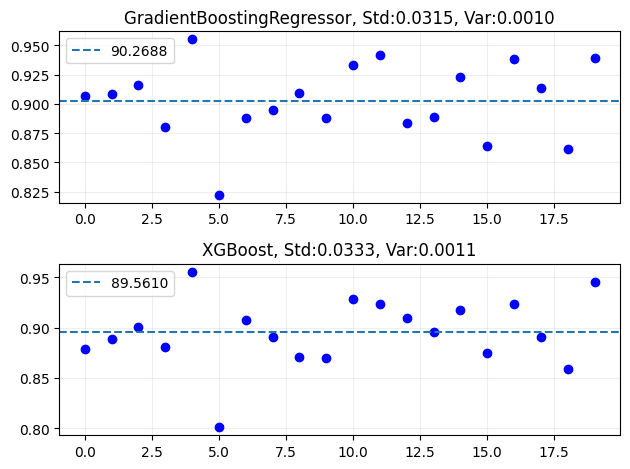

In [56]:
names = ['GradientBoostingRegressor','XGBoost']
scores = {name:{} for name in names}
x_train = xtrain #using log trasformed values instead of raw values
y_train = np.log(ytrain).values.reshape(xtrain.shape[0],)
for idx,models in enumerate( [boostingTress,xgb]):
  scores[names[idx]]['r2'] = cross_val_score(models,x_train,y_train,cv=20)

idx = 0
for name,score in scores.items():
  plt.subplot(2,1,idx+1)
  plt.plot(score['r2'],'bo')
  plt.axhline(score['r2'].mean(),linestyle='--',label=f'{score["r2"].mean()*100:.4f}')
  plt.legend()
  plt.grid(alpha=0.2)
  plt.title(f'{name}, Std:{score["r2"].std():.4f}, Var:{(score["r2"].std())**2:.4f}')
  idx+=1
plt.tight_layout()

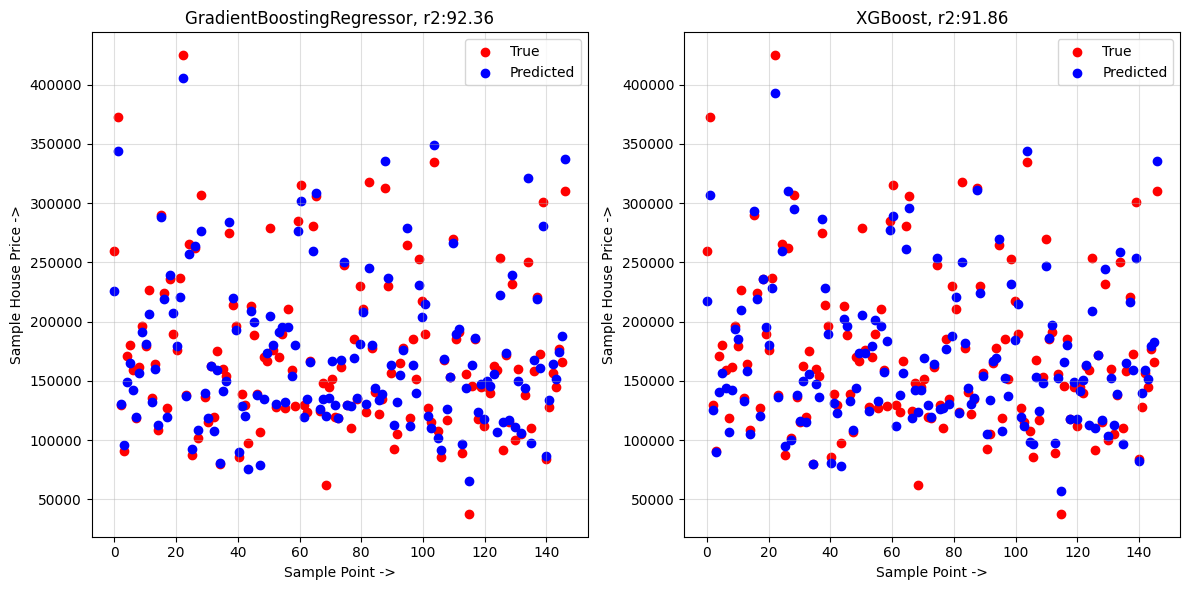

In [57]:
plt.figure(figsize=(12,6))
residual = {name:[] for name in names}
for idx,model in enumerate([boostingTress,xgb]):
  plt.subplot(1,2,idx+1)
  model.fit(xtrain,np.log(ytrain).values.reshape(xtrain.shape[0],))
  true = np.array(ytest)
  predicted = np.exp(model.predict(xtest))
  plt.scatter(np.linspace(0,len(ytest),len(ytest)),true,color='red',label='True')
  plt.scatter(np.linspace(0,len(ytest),len(ytest)),predicted,color='blue',label='Predicted')
  plt.xlabel('Sample Point ->')
  plt.ylabel('Sample House Price ->')
  residual[names[idx]] = (true-predicted)
  plt.title(f'{names[idx]}, r2:{r2_score(true,predicted)*100:.2f}')
  plt.grid(alpha=0.4)
  plt.legend()
plt.tight_layout()

In [62]:
np.linspace(0,xtrain.shape[0],xtrain.shape[0]).shape

(1314,)

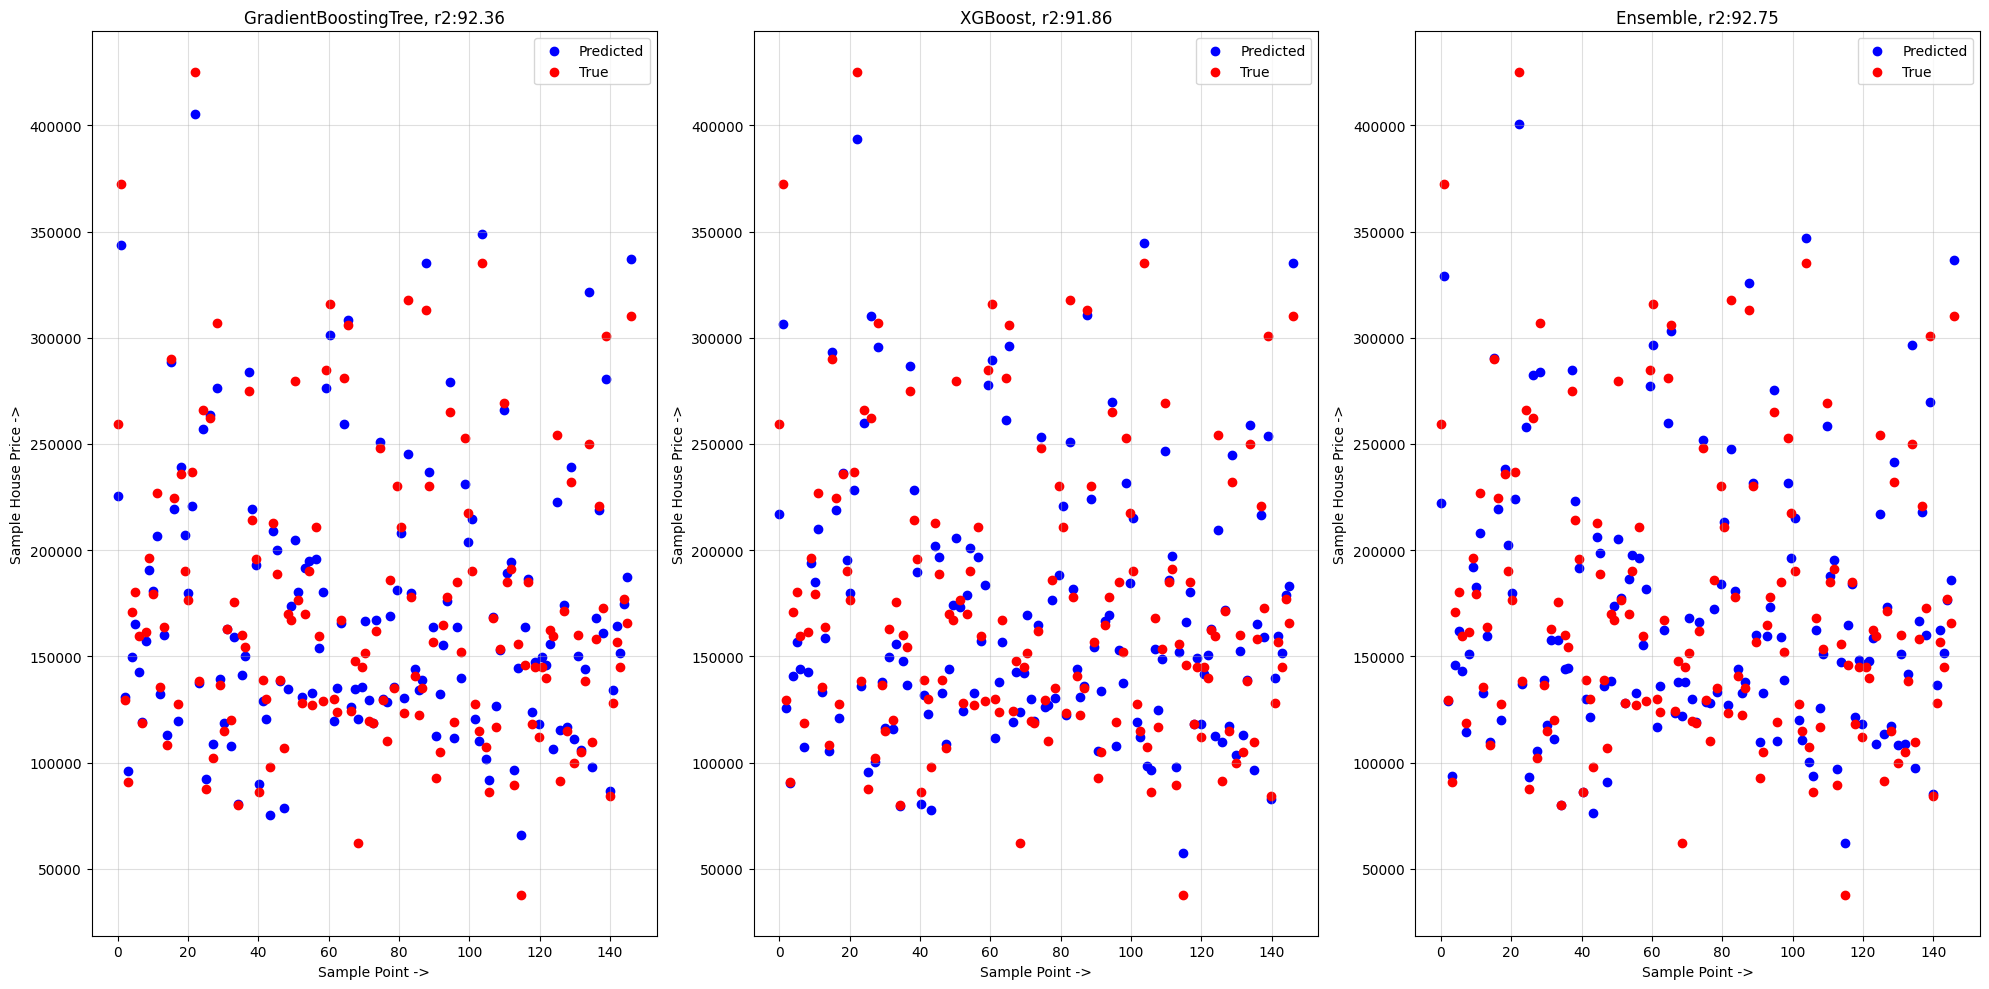

In [70]:
#try ensemlbe
predictions = [np.exp(boostingTress.predict(xtest)),np.exp(xgb.predict(xtest)),0.6*np.exp(boostingTress.predict(xtest))+0.4*np.exp(xgb.predict(xtest))]
titles = ['GradientBoostingTree','XGBoost','Ensemble']
plt.figure(figsize=(20,10))
for idx,preds in enumerate(predictions):
  plt.subplot(1,len(predictions),idx+1)
  x = np.linspace(0,xtest.shape[0],xtest.shape[0])
  plt.scatter(x,preds,color='blue',label='Predicted')
  plt.scatter(x,ytest,color='red',label='True')
  plt.title(f'{titles[idx]}, r2:{r2_score(ytest,preds)*100:.2f}')
  plt.xlabel('Sample Point ->')
  plt.ylabel('Sample House Price ->')
  plt.legend()
  plt.grid(alpha=0.4)
plt.tight_layout()

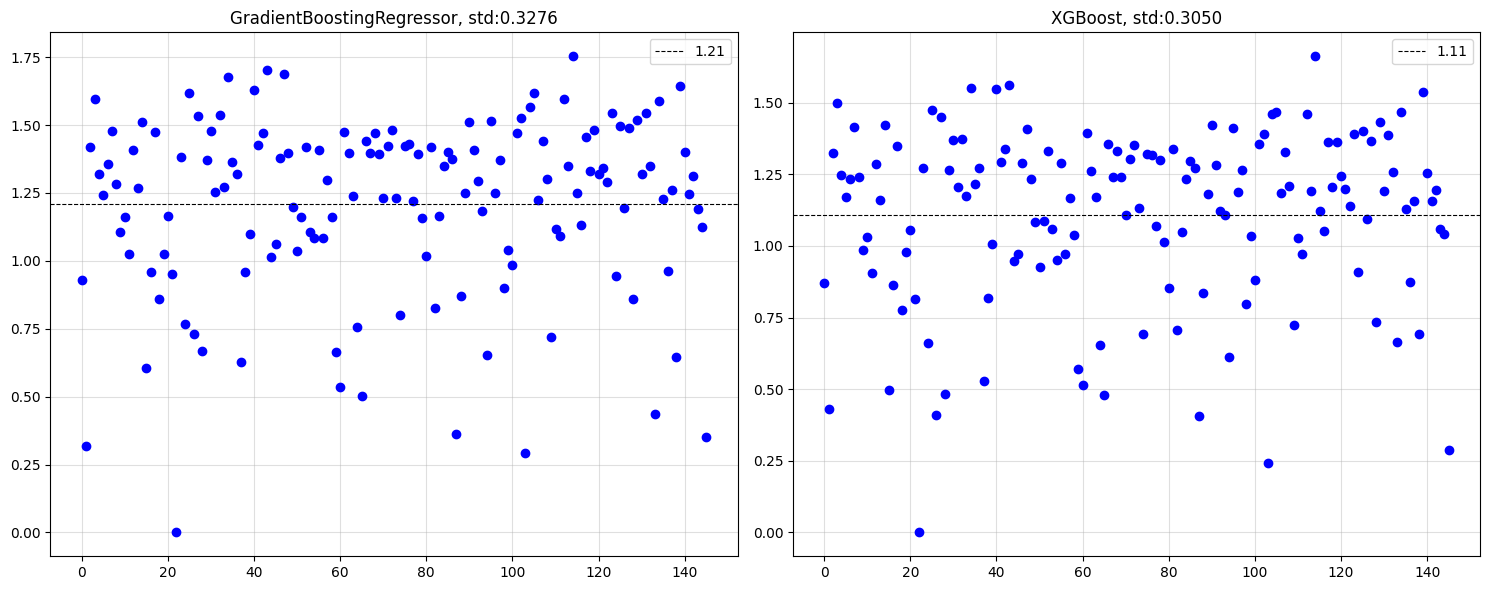

In [58]:
plt.figure(figsize=(15,6))
for idx,model in enumerate([boostingTress,xgb]):
  plt.subplot(1,2,idx+1)
  # model.fit(xtrain,np.log(ytrain).values.reshape(xtrain.shape[0],))
  # true = np.array(ytest)
  # predicted = np.exp(model.predict(xtest))
  # plt.scatter(np.linspace(0,len(ytest),len(ytest)),true,color='red',label='True')
  result = residual[names[idx]][0]
  result = (result-result.min())/result.max()
  plt.plot(result,'bo')
  plt.axhline(result.mean(),linestyle='--',color='black',lw=0.8,label=f'{result.mean():.2f}')
  # residual[names[idx]].append(true-predicted)
  plt.title(f'{names[idx]}, std:{np.std(result):.4f}')
  plt.grid(alpha=0.4)
  plt.legend()
plt.tight_layout()


In [34]:
#hyper parameter tuning
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
param_grid = [{
    'n_estimators':[250],
    'learning_rate':[0.1,0.12,0.23],
    'max_depth':[5,6,7],
    'subsample':[0.8,0.7,0.6,0.5],
    'reg_alpha':[0.12,0.15,0.11,0.25],
    'reg_lambda':[0.01,0.02,0.015,0.024],
    'gamma':[0,0.8,0.7,0.5],
}]

In [53]:
grid = [{
    'n_estimators':[275,300,350],
    'learning_rate':[0.01,0.1,0.2,0.3],
    'max_depth':[3,4,5,6,7,8],
    'subsample':[0.9,0.8,0.7,1],
    'max_leaf_nodes':[None,2,50,60,10,13],
}]

configs_tree = {}
epochs = 12
for i in range(epochs):
  print(f'Starting the iteration-{i+1}')
  grid_search = RandomizedSearchCV(
    boostingTress,
    grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
  )
  grid_search.fit(xtrain,np.log(ytrain).values.reshape(xtrain.shape[0],))
  print(f'Completed the iteration-{i+1}')
  configs_tree[f'iteration-{i+1}'] = {'r12 score':grid_search.best_score_,
                                              'params':grid_search.best_params_}

Starting the iteration-1
Completed the iteration-1
Starting the iteration-2
Completed the iteration-2
Starting the iteration-3
Completed the iteration-3
Starting the iteration-4
Completed the iteration-4
Starting the iteration-5
Completed the iteration-5
Starting the iteration-6
Completed the iteration-6
Starting the iteration-7
Completed the iteration-7
Starting the iteration-8
Completed the iteration-8
Starting the iteration-9
Completed the iteration-9
Starting the iteration-10
Completed the iteration-10
Starting the iteration-11
Completed the iteration-11
Starting the iteration-12
Completed the iteration-12


In [54]:
configs_tree

{'iteration-1': {'r12 score': np.float64(0.8916739936127518),
  'params': {'subsample': 0.8,
   'n_estimators': 275,
   'max_leaf_nodes': 10,
   'max_depth': 4,
   'learning_rate': 0.1}},
 'iteration-2': {'r12 score': np.float64(0.8881041648962406),
  'params': {'subsample': 0.9,
   'n_estimators': 275,
   'max_leaf_nodes': None,
   'max_depth': 5,
   'learning_rate': 0.1}},
 'iteration-3': {'r12 score': np.float64(0.8823092460663086),
  'params': {'subsample': 0.8,
   'n_estimators': 350,
   'max_leaf_nodes': 2,
   'max_depth': 7,
   'learning_rate': 0.2}},
 'iteration-4': {'r12 score': np.float64(0.8809404616731824),
  'params': {'subsample': 0.9,
   'n_estimators': 300,
   'max_leaf_nodes': 2,
   'max_depth': 7,
   'learning_rate': 0.1}},
 'iteration-5': {'r12 score': np.float64(0.8863621694464932),
  'params': {'subsample': 0.9,
   'n_estimators': 350,
   'max_leaf_nodes': 10,
   'max_depth': 6,
   'learning_rate': 0.1}},
 'iteration-6': {'r12 score': np.float64(0.888526454972494),

In [44]:
configs = {}
epochs = 12
for i in range(epochs):
  print(f'Starting the iteration-{i+1}')
  grid_search = RandomizedSearchCV(
    xgb,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
  )
  grid_search.fit(xtrain,np.log(ytrain).values.reshape(xtrain.shape[0],))
  print(f'Completed the iteration-{i+1}')
  configs[f'iteration-{i+1}'] = {'r12 score':grid_search.best_score_,
                                              'params':grid_search.best_params_}

Starting the iteration-1
Completed the iteration-1
Starting the iteration-2
Completed the iteration-2
Starting the iteration-3
Completed the iteration-3
Starting the iteration-4
Completed the iteration-4
Starting the iteration-5
Completed the iteration-5
Starting the iteration-6
Completed the iteration-6
Starting the iteration-7
Completed the iteration-7
Starting the iteration-8
Completed the iteration-8
Starting the iteration-9
Completed the iteration-9
Starting the iteration-10
Completed the iteration-10
Starting the iteration-11
Completed the iteration-11
Starting the iteration-12
Completed the iteration-12


In [45]:
configs

{'iteration-1': {'r12 score': np.float64(0.8837499543092843),
  'params': {'subsample': 0.5,
   'reg_lambda': 0.01,
   'reg_alpha': 0.25,
   'n_estimators': 250,
   'max_depth': 5,
   'learning_rate': 0.12,
   'gamma': 0}},
 'iteration-2': {'r12 score': np.float64(0.8788710723008464),
  'params': {'subsample': 0.7,
   'reg_lambda': 0.01,
   'reg_alpha': 0.15,
   'n_estimators': 250,
   'max_depth': 6,
   'learning_rate': 0.12,
   'gamma': 0}},
 'iteration-3': {'r12 score': np.float64(0.8834404997499602),
  'params': {'subsample': 0.8,
   'reg_lambda': 0.015,
   'reg_alpha': 0.12,
   'n_estimators': 250,
   'max_depth': 5,
   'learning_rate': 0.12,
   'gamma': 0}},
 'iteration-4': {'r12 score': np.float64(0.8889117754064422),
  'params': {'subsample': 0.5,
   'reg_lambda': 0.024,
   'reg_alpha': 0.25,
   'n_estimators': 250,
   'max_depth': 5,
   'learning_rate': 0.1,
   'gamma': 0}},
 'iteration-5': {'r12 score': np.float64(0.88328100800524),
  'params': {'subsample': 0.7,
   'reg_lamb

In [ ]:
#  'iteration-4': {'r12 score': np.float64(0.8889117754064422),
#   'params': {'subsample': 0.5,
#    'reg_lambda': 0.024,
#    'reg_alpha': 0.25,
#    'n_estimators': 250,
#    'max_depth': 5,
#    'learning_rate': 0.1,
#    'gamma': 0}},

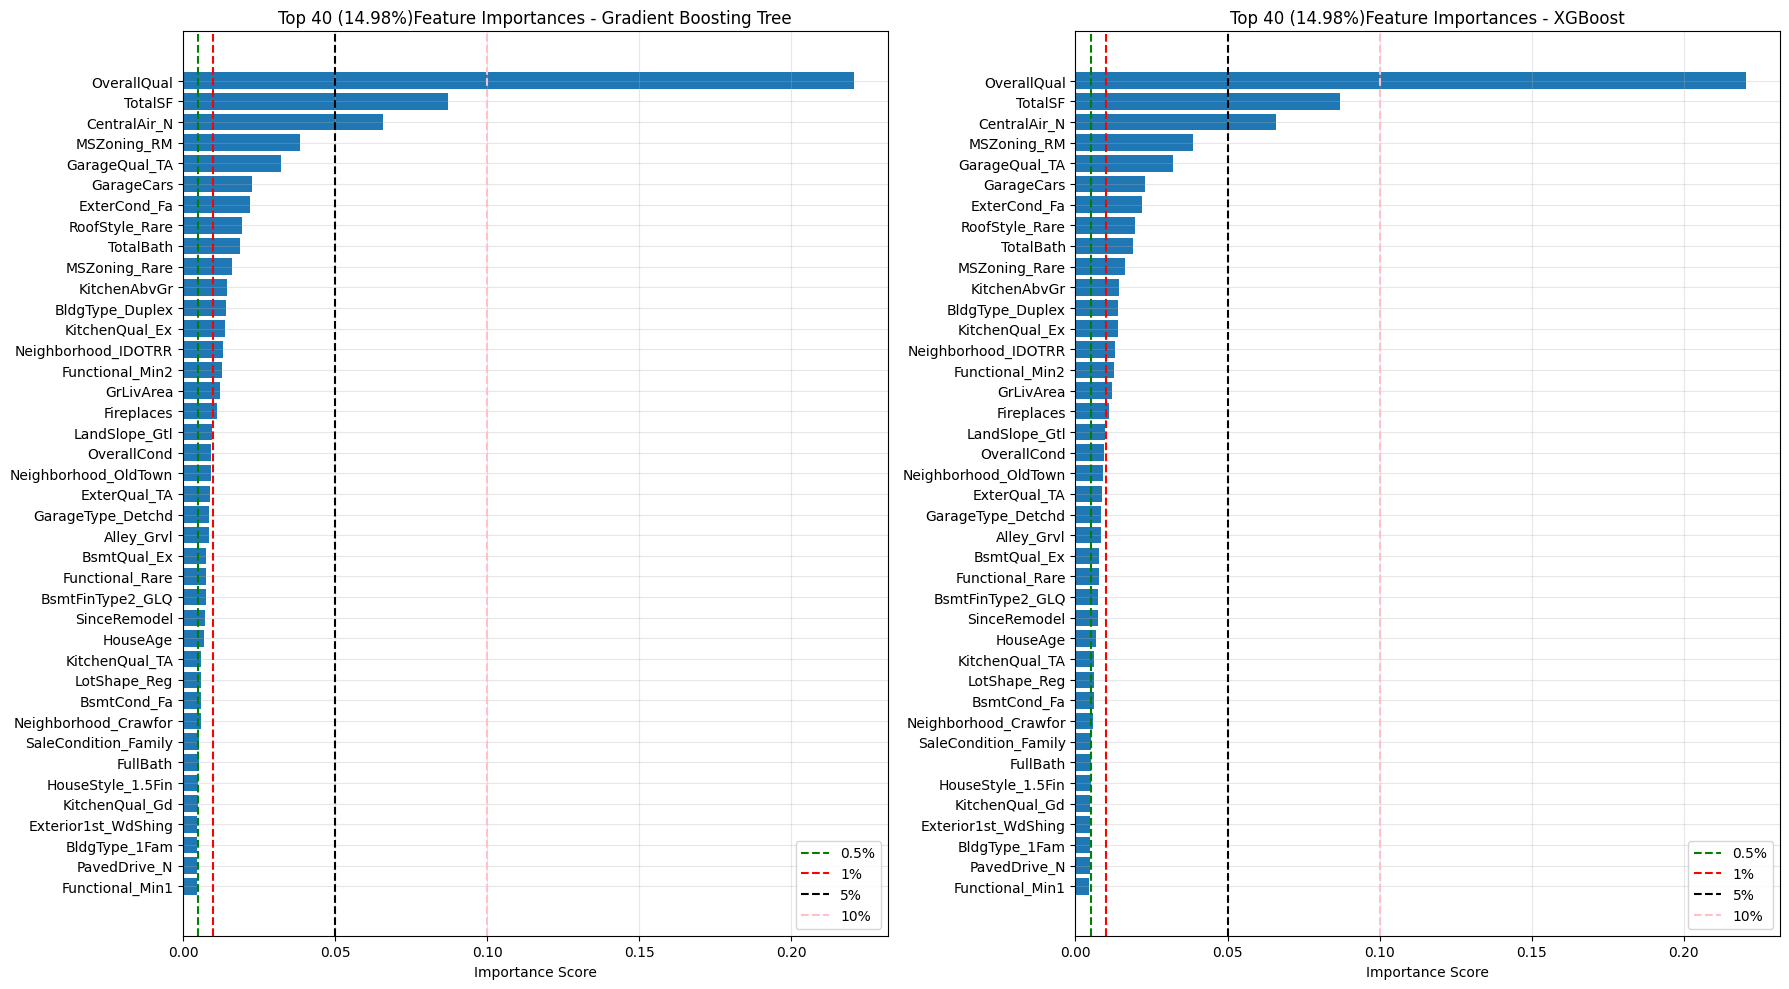

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

k =40
importances_boostingTree = boostingTress.feature_importances_
importances_xgb = xgb.feature_importances_


feature_names = xtrain.columns 


tree_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})


xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

tree_importance = tree_importance.sort_values(by='Importance', ascending=False).head(k)
xgb_importance = xgb_importance.sort_values(by='Importance', ascending=False).head(k)
model_name = ['Gradient Boosting Tree','XGBoost']


plt.figure(figsize=(18, 10))
for idx,frame in enumerate([tree_importance,xgb_importance]):
  plt.subplot(1,2,idx+1)
  plt.barh(frame['Feature'][::-1], frame['Importance'][::-1])
  plt.axvline(x=0.005,label=f'0.5%',linestyle='--',color='green')
  plt.axvline(x=0.01,label=f'1%',linestyle='--',color='red')
  plt.axvline(x=0.05,label=f'5%',linestyle='--',color='black')
  plt.axvline(x=0.1,label=f'10%',linestyle='--',color='pink')
  plt.xlabel('Importance Score')
  plt.grid(alpha=0.3)
  plt.legend()
  plt.title(f'Top {k} ({(k/xtrain.shape[1])*100:.2f}%)Feature Importances - {model_name[idx]}')
plt.tight_layout()

In [117]:
import joblib

joblib.dump(boostingTress,'GradientBoostedTreeModel.pkl')
joblib.dump(xgb,'XGBoostModel.pkl')

['XGBoostModel.pkl']

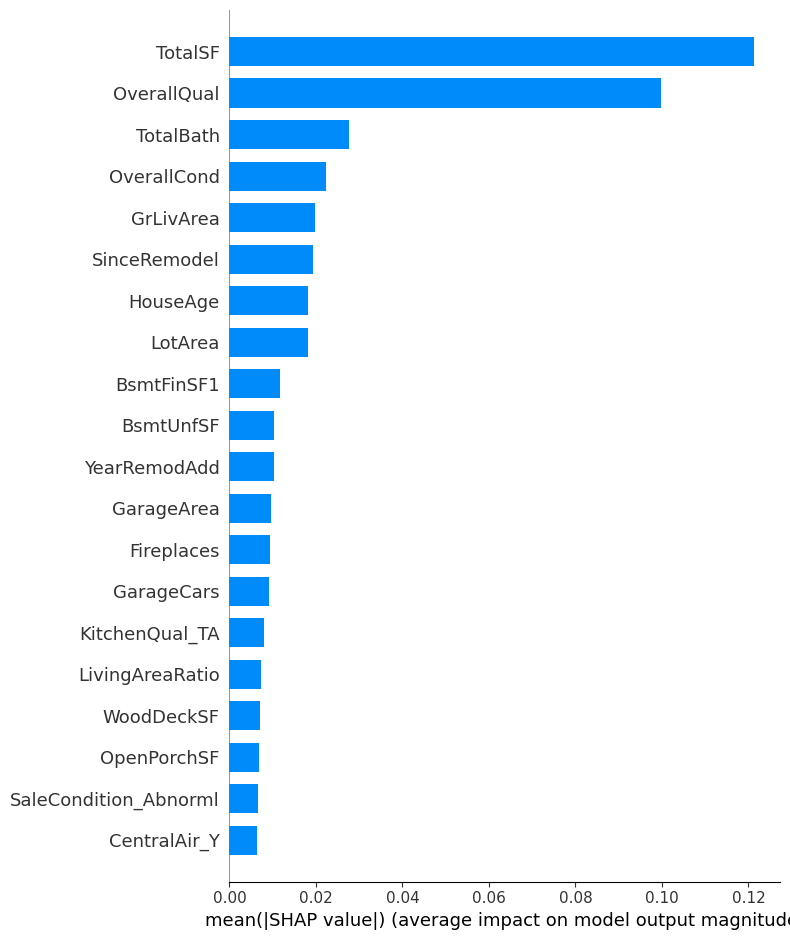

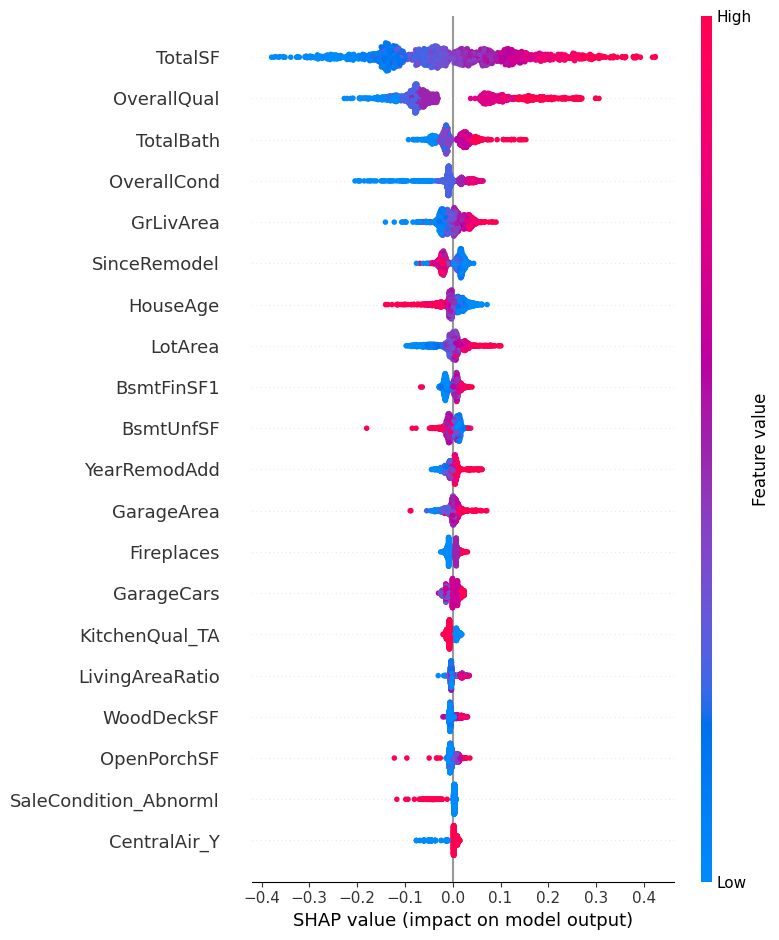

In [132]:
import shap

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(boostingTress)  # or xgb_model
shap_values = explainer.shap_values(xtrain)

# Summary plot
shap.summary_plot(shap_values, xtrain, plot_type="bar")  # bar plot of mean(|SHAP|) per feature
shap.summary_plot(shap_values, xtrain)  # beeswarm plot